In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

# some pandas options
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

sats = 100000000

In [8]:
%%bigquery summary
SELECT SUM(CASE WHEN m.tx_hash IS NOT NULL AND b.tx_hash IS NOT NULL THEN 1 ELSE 0 END) AS in_mempool_and_mined
     , SUM(CASE WHEN m.tx_hash IS NULL AND b.tx_hash IS NOT NULL THEN 1 ELSE 0 END) AS never_in_mempool_and_mined
     , SUM(CASE WHEN m.tx_hash IS NOT NULL AND b.tx_hash IS NULL THEN 1 ELSE 0 END) AS in_mempool_and_never_mined
     , COUNT(m.tx_hash) AS mempool_total
     , COUNT(b.tx_hash) AS blockchain_total
  FROM
(
    SELECT tx_hash from `bitcoin-data-analysis-320014.transaction_analysis.mempool_txs`
     WHERE first_seen_timestamp BETWEEN '2015-07-01' AND '2022-04-20' ) m 
FULL OUTER JOIN
(
    SELECT `hash` as tx_hash FROM `bigquery-public-data.crypto_bitcoin.transactions` 
     WHERE block_timestamp between '2015-07-01' and '2022-04-20'
) b on m.tx_hash = b.tx_hash;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/rows]


In [28]:
summary

,in_mempool_and_mined,never_in_mempool_and_mined,in_mempool_and_never_mined,mempool_total,blockchain_total
0,525051135,127919419,5710068,530761203,652970554


In [27]:
print(f"mined but not in mempool txs: {summary['never_in_mempool_and_mined'].values[0]/summary['blockchain_total'].values[0]:.2%}")
print(f"in mempool but never mined: {summary['in_mempool_and_never_mined'].values[0]/summary['blockchain_total'].values[0]:.2%}")

mined but not in mempool txs: 19.59%
in mempool but never mined: 0.87%


In [29]:
%%bigquery daily_counts
  select DATE_TRUNC(block_timestamp, DAY) as block_day
       , count(*) AS total
    from `bitcoin-data-analysis-320014.transaction_analysis.mempool_txs`
   GROUP BY 1;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2791/2791 [00:01<00:00, 1810.41rows/s]


<AxesSubplot:xlabel='block_day'>

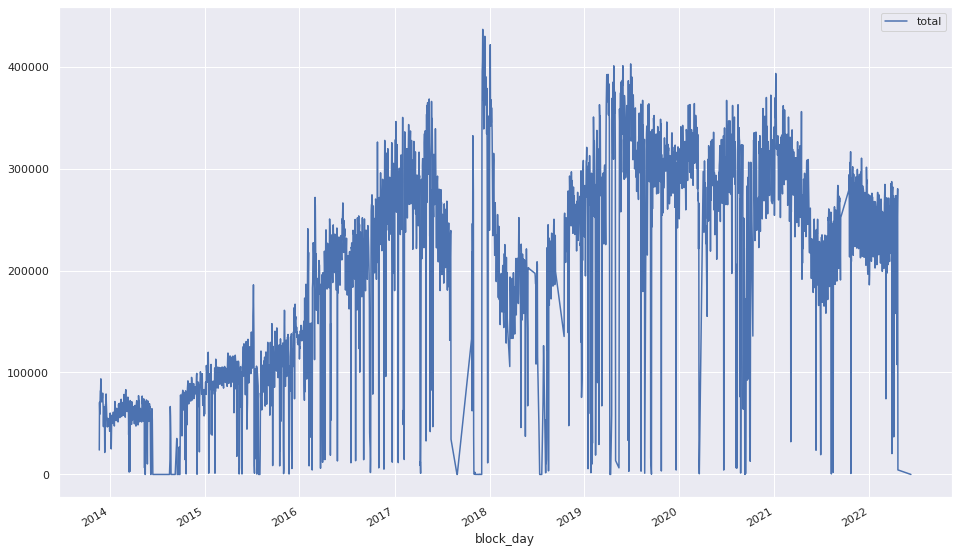

In [54]:
daily_counts.set_index(pd.DatetimeIndex(daily_counts['block_day'])).drop('block_day', axis=1).plot(figsize=(16,10))

<AxesSubplot:xlabel='block_day'>

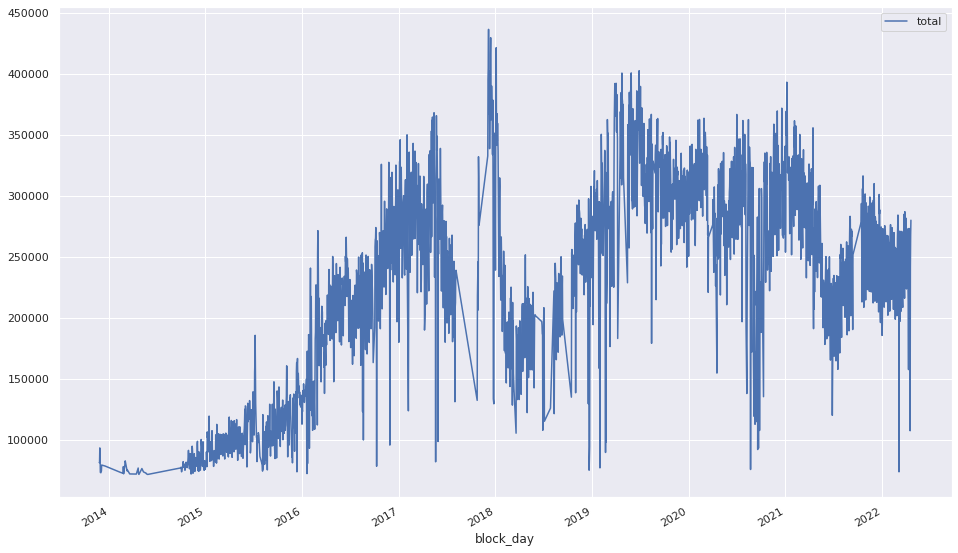

In [55]:
dc_dt = daily_counts.set_index(pd.DatetimeIndex(daily_counts['block_day'])).drop('block_day', axis=1)

dc_dt[dc_dt['total'] > 144 * 1000 * .5 ].plot(figsize=(16,10))

<AxesSubplot:xlabel='block_day'>

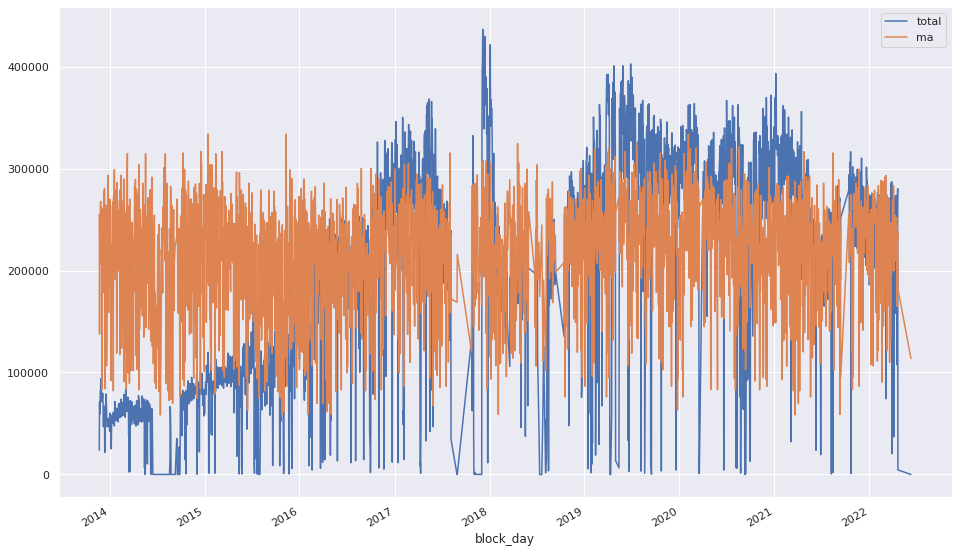

In [67]:
dc_dt['ma'] = dc_dt['total'].fillna(0).rolling(10).median()
dc_dt.plot(figsize=(16,10))

<AxesSubplot:xlabel='block_day'>

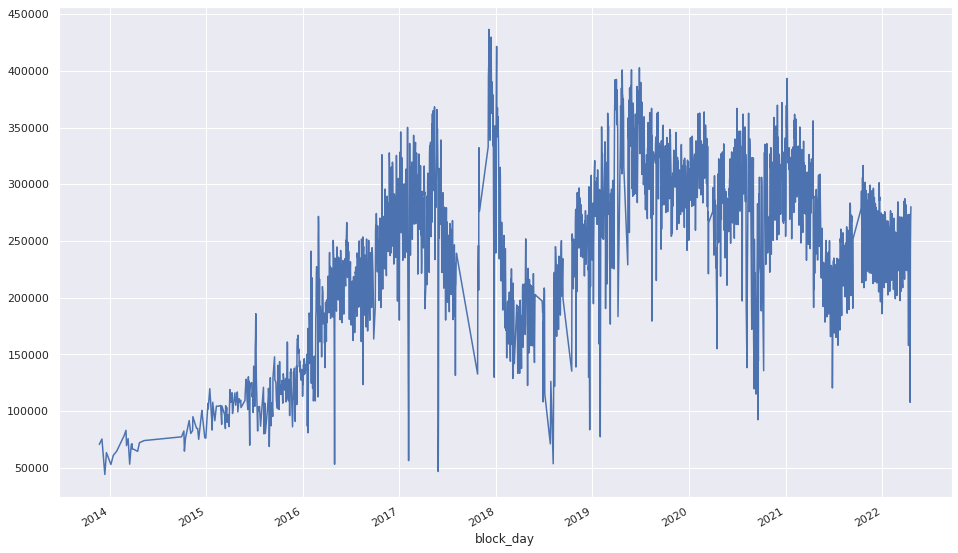

In [74]:
dc_dt[dc_dt['total'] > dc_dt['ma'] * .5 ]['total'].plot(figsize=(16,10))

In [75]:
%%bigquery mempool
SELECT block_day
     , COUNT(*) AS txs_total
     , AVG(block_wait_time) AS mean_wait_time
     , AVG(p25) AS p25
     , AVG(p50) AS p50
     , AVG(p75) AS p75
  FROM (
SELECT DATE_TRUNC(block_timestamp, DAY) AS block_day
     , TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE) AS block_wait_time
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.25) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) as p25
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.5) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p50
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.75) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p75
  FROM `bitcoin-data-analysis-320014.transaction_analysis.mempool_txs`
 WHERE 1=1
   AND first_seen_timestamp BETWEEN '2015-07-01' AND '2022-04-20'
    -- only check for confirmed txs
   AND block_timestamp IS NOT NULL
    -- remove anomalous tx: this paid below minFeeRate and took 3 years to confirm
    -- AND tx_hash NOT IN ('b32c6d12bb7828b9624754bcb194b62c00bc7d3716ce4b462e338949d7513a0a')
  ) GROUP BY 1;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:01<00:00, 1380.67rows/s]


In [76]:
mp_dt = mempool.set_index(pd.DatetimeIndex(mempool['block_day'])).drop('block_day', axis=1)

<AxesSubplot:xlabel='block_day'>

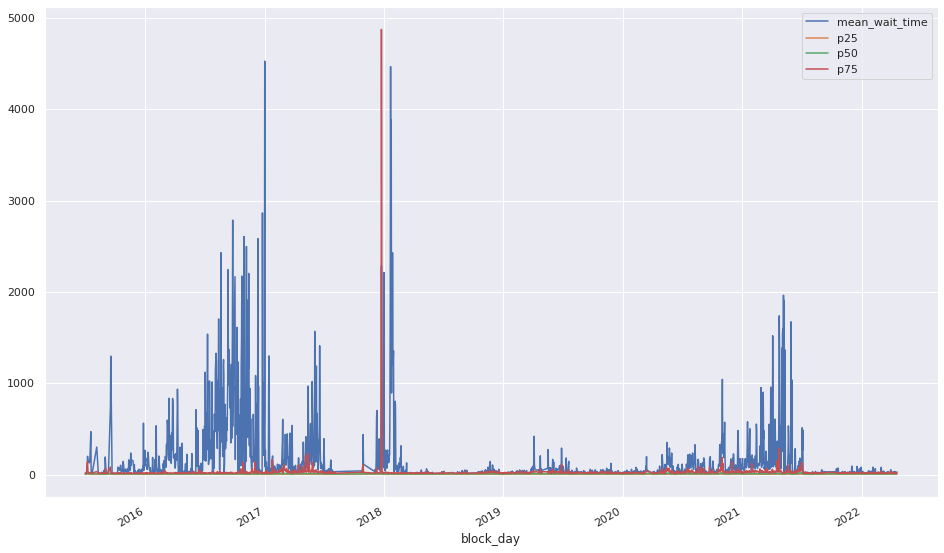

In [111]:
mp_dt[mp_dt['txs_total'] > 100000][['mean_wait_time', 'p25', 'p50', 'p75']].plot(figsize=(16,10))

In [83]:
daily_counts.describe()

,total
count,2.791000e+03
mean,2.035086e+05
std,1.504299e+05
min,1.000000e+00
25%,1.023220e+05
50%,2.265640e+05
75%,2.878530e+05
max,5.836270e+06


In [84]:
%%bigquery mempool_month
SELECT block_month
     , COUNT(*) AS txs_total
     , AVG(block_wait_time) AS mean_wait_time
     , AVG(p25) AS p25
     , AVG(p50) AS p50
     , AVG(p75) AS p75
  FROM (
SELECT DATE_TRUNC(block_timestamp, MONTH) AS block_month
     , TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE) AS block_wait_time
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.25) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) as p25
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.5) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p50
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.75) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p75
  FROM `bitcoin-data-analysis-320014.transaction_analysis.mempool_txs`
 WHERE 1=1
   AND first_seen_timestamp BETWEEN '2015-07-01' AND '2022-04-20'
    -- only check for confirmed txs
   AND block_timestamp IS NOT NULL
    -- remove anomalous tx: this paid below minFeeRate and took 3 years to confirm
    -- AND tx_hash NOT IN ('b32c6d12bb7828b9624754bcb194b62c00bc7d3716ce4b462e338949d7513a0a')
  ) GROUP BY 1;

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:01<00:00, 45.15rows/s]


In [85]:
%%bigquery mempool_year
SELECT block_year
     , COUNT(*) AS txs_total
     , AVG(block_wait_time) AS mean_wait_time
     , AVG(p25) AS p25
     , AVG(p50) AS p50
     , AVG(p75) AS p75
  FROM (
SELECT DATE_TRUNC(block_timestamp, YEAR) AS block_year
     , TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE) AS block_wait_time
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.25) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) as p25
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.5) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p50
     , PERCENTILE_CONT(TIMESTAMP_DIFF(block_timestamp, first_seen_timestamp, MINUTE), 0.75) OVER(PARTITION BY DATE_TRUNC(block_timestamp, DAY)) AS p75
  FROM `bitcoin-data-analysis-320014.transaction_analysis.mempool_txs`
 WHERE 1=1
   AND first_seen_timestamp BETWEEN '2015-07-01' AND '2022-04-20'
    -- only check for confirmed txs
   AND block_timestamp IS NOT NULL
    -- remove anomalous tx: this paid below minFeeRate and took 3 years to confirm
    -- AND tx_hash NOT IN ('b32c6d12bb7828b9624754bcb194b62c00bc7d3716ce4b462e338949d7513a0a')
  ) GROUP BY 1;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18rows/s]


In [86]:
mp_month = mempool_month.set_index(pd.DatetimeIndex(mempool_month['block_month'])).drop('block_month', axis=1)
mp_year = mempool_year.set_index(pd.DatetimeIndex(mempool_year['block_year'])).drop('block_year', axis=1)

<AxesSubplot:xlabel='block_month'>

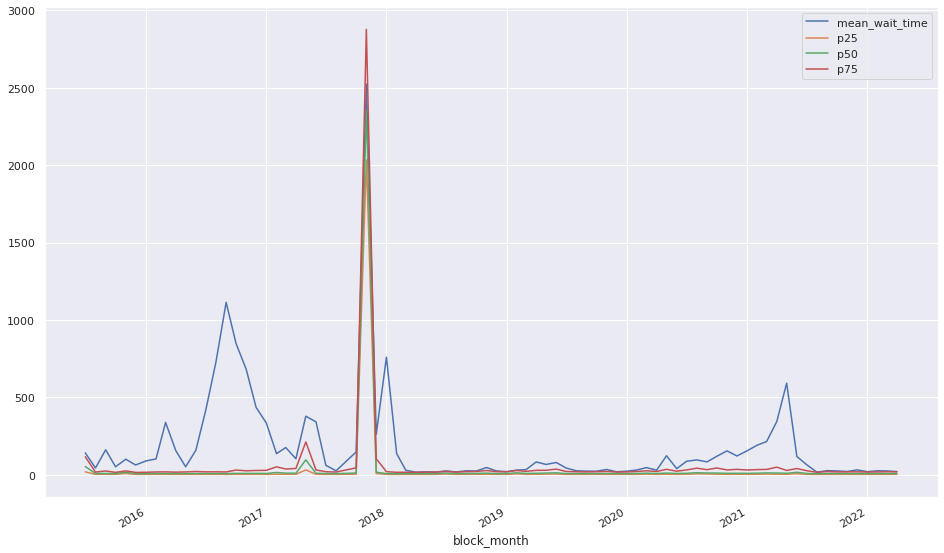

In [90]:
mp_month[mp_month['txs_total'] > 1][['mean_wait_time', 'p25', 'p50', 'p75']].plot(figsize=(16,10))

<AxesSubplot:xlabel='block_year'>

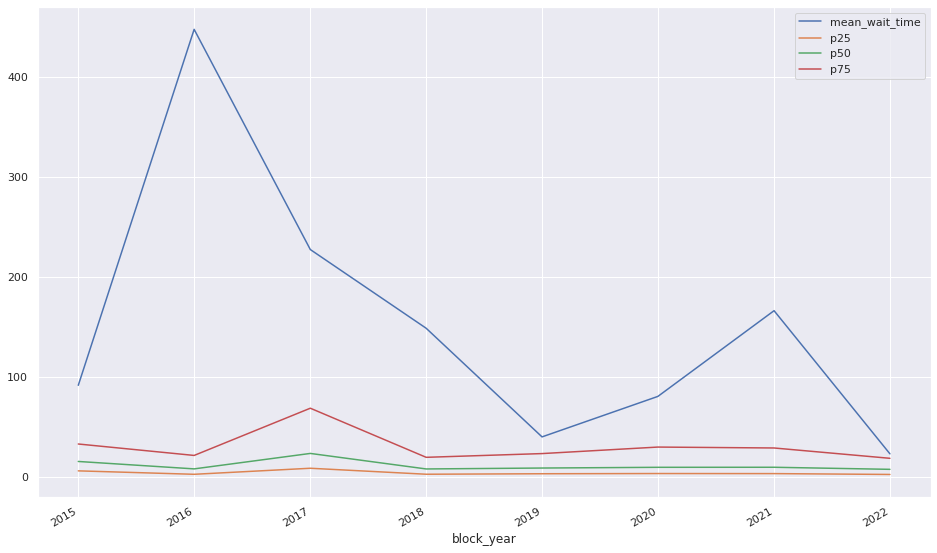

In [93]:
mp_year[mp_year['txs_total'] > 1][['mean_wait_time', 'p25', 'p50', 'p75']].plot(figsize=(16,10))

In [89]:
mp_year.sort_index()

,txs_total,mean_wait_time,p25,p50,p75
block_year,,,,,
2015-01-01 00:00:00+00:00,18667961,92.046087,6.504626,15.901624,33.360128
2016-01-01 00:00:00+00:00,73616332,447.917816,3.072553,8.482846,21.927111
2017-01-01 00:00:00+00:00,67843015,227.777836,9.111532,23.932252,69.140431
2018-01-01 00:00:00+00:00,57792262,149.077621,3.132867,8.411786,20.044021
2019-01-01 00:00:00+00:00,98965490,40.469083,3.622410,9.331507,23.778295
2020-01-01 00:00:00+00:00,95369668,80.943511,3.833207,10.056466,30.293837
2021-01-01 00:00:00+00:00,86491440,166.646655,3.763213,10.102592,29.378062
2022-01-01 00:00:00+00:00,26309823,23.545966,2.917850,8.028044,19.055928


In [98]:
%%bigquery blocks
SELECT * FROM `bitcoin-data-analysis-320014.transaction_analysis.blocks_with_mempool`
where block_timestamp between '2015-07-01' and '2022-04-20'

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349920/349920 [00:04<00:00, 70381.06rows/s]


In [100]:
b_dt = blocks.set_index(pd.DatetimeIndex(blocks['block_timestamp'])).drop('block_timestamp', axis=1)

<AxesSubplot:>

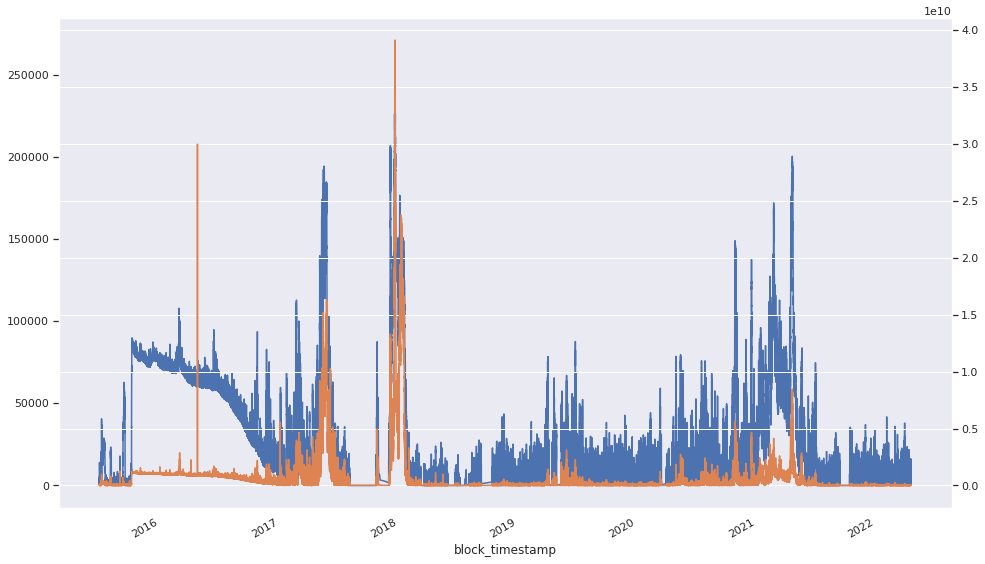

In [109]:
b_dt['pending_txs'].plot(figsize=(16,10))
b_dt['pending_fees'].astype(float).plot(secondary_y=True)

In [112]:
blocks

,block_number,block_timestamp,pending_txs,pending_size,pending_virtual_size,pending_fees,pending_value
0,509203,2018-02-14 19:31:23+00:00,10753,65053896,64484096,122821614.000000000,930332055506.000000000
1,509076,2018-02-14 01:38:38+00:00,4610,22876418,22275294,45257532.000000000,1063403591060.000000000
2,509217,2018-02-14 20:44:22+00:00,9220,63907713,63467517,86228593.000000000,417519619306.000000000
3,509154,2018-02-14 12:36:08+00:00,11524,56018646,55333287,98553677.000000000,1259718301117.000000000
4,509111,2018-02-14 05:52:16+00:00,6661,32348270,31773692,89190664.000000000,4216589134735.000000000
...,...,...,...,...,...,...,...
349915,511417,2018-03-01 05:05:24+00:00,7673,46169253,44694453,107807006.000000000,1622598818560.000000000
349916,511473,2018-03-01 13:34:15+00:00,6907,27552263,27136653,173875034.000000000,1922606424465.000000000
349917,511524,2018-03-01 20:33:53+00:00,2046,11143168,10865780,37536392.000000000,491803941351.000000000
349918,511514,2018-03-01 19:19:34+00:00,2046,15223227,14985117,44707563.000000000,460409281082.000000000
